### **Colorizing black and white images is an amazingly useful and incredible technique achieved by deep learning.** 

[Colorful Image Colorization ](http://arxiv.org/pdf/1603.08511.pdf) 

- The authors embrace the underlying uncertainty of the problem (black and white to color conversion) by posing it as a classification task and use class-rebalancing at training time to increase the diversity of colors in the result. 
- The system is implemented as a feed-forward pass in a CNN at test time and is trained on over a million color images. 
- They evaluate our algorithm using a “colorization Turing test,” asking human participants to choose between a generated and ground truth color image. 
- Their method successfully fools humans on 32% of the trials, significantly higher than previous methods.

![](http://richzhang.github.io/colorization/resources/images/teaser3.jpg)

by Richard Zhang, Phillip Isola, Alexei A. Efros. In ECCV, 2016.

We'll be using the following Caffe model files that we'll download in the next cell below. These will be then loaded into OpenCV:

1. colorization_deploy_v2.prototext
2. colorization_release_v2.caffe
3. pts_in_hull.npy

In [1]:
-0# Our Setup, Import Libaries, Create our Imshow Function and Download our Images
import cv2
import numpy as np
from os import listdir
from os.path import isfile, join
from matplotlib import pyplot as plt

# Define our imshow function 
def imshow(title = "Image", image = None, size = 10):
    w, h = image.shape[0], image.shape[1]
    aspect_ratio = w/h
    plt.figure(figsize=(size * aspect_ratio,size))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.show()

# Download and unzip our images
!wget https://moderncomputervision.s3.eu-west-2.amazonaws.com/colorize.zip
!unzip -qq colorize.zip

--2022-07-30 09:08:47--  https://moderncomputervision.s3.eu-west-2.amazonaws.com/colorize.zip
Resolving moderncomputervision.s3.eu-west-2.amazonaws.com (moderncomputervision.s3.eu-west-2.amazonaws.com)... 3.5.246.154
Connecting to moderncomputervision.s3.eu-west-2.amazonaws.com (moderncomputervision.s3.eu-west-2.amazonaws.com)|3.5.246.154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 120120413 (115M) [application/zip]
Saving to: ‘colorize.zip’

colorize.zip        100%[===================>] 114.56M  31.0MB/s    in 4.2s    

2022-07-30 09:08:51 (27.1 MB/s) - ‘colorize.zip’ saved [120120413/120120413]



In [3]:

# Script is based on https://github.com/richzhang/colorization/blob/master/colorize.py
# To download the caffemodel and the prototxt, see: https://github.com/richzhang/colorization/tree/master/models
# To download pts_in_hull.npy, see: https://github.com/richzhang/colorization/blob/master/resources/pts_in_hull.npy

# Get our images
file_path = "/content/"
blackandwhite_imgs = [f for f in listdir(file_path) if isfile(join(file_path, f))]
kernel = 'colorize/pts_in_hull.npy'

# Start the main program
if __name__ == '__main__':

    # Select desired model
    net = cv2.dnn.readNetFromCaffe("colorize/colorization_deploy_v2.prototxt",
                               "colorize/colorization_release_v2.caffemodel")

    # load cluster centers
    pts_in_hull = np.load(kernel) 

    # populate cluster centers as 1x1 convolution kernel
    pts_in_hull = pts_in_hull.transpose().reshape(2, 313, 1, 1)
    net.getLayer(net.getLayerId('class8_ab')).blobs = [pts_in_hull.astype(np.float32)]
    net.getLayer(net.getLayerId('conv8_313_rh')).blobs = [np.full([1, 313], 2.606, np.float32)]

In [4]:
def func(image):
        img = cv2.imread(image)
        
        img_rgb = (img[:,:,[2, 1, 0]] * 1.0 / 255).astype(np.float32)
        img_lab = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2LAB)
        
        # pull out L channel
        img_l = img_lab[:,:,0]
        
        # get original image size
        (H_orig,W_orig) = img_rgb.shape[:2] 

        # resize image to network input size
        img_rs = cv2.resize(img_rgb, (224, 224)) 
        
        # resize image to network input size
        img_lab_rs = cv2.cvtColor(img_rs, cv2.COLOR_RGB2Lab)
        img_l_rs = img_lab_rs[:,:,0]
        
        # subtract 50 for mean-centering
        img_l_rs -= 50 

        net.setInput(cv2.dnn.blobFromImage(img_l_rs))
        
        # this is our result
        ab_dec = net.forward('class8_ab')[0,:,:,:].transpose((1,2,0)) 

        (H_out,W_out) = ab_dec.shape[:2]
        ab_dec_us = cv2.resize(ab_dec, (W_orig, H_orig))
        img_lab_out = np.concatenate((img_l[:,:,np.newaxis],ab_dec_us),axis=2) 
        
        # concatenate with original image L
        img_bgr_out = np.clip(cv2.cvtColor(img_lab_out, cv2.COLOR_Lab2BGR), 0, 1)

        # show original image
        imshow('Original', img)
        # Resize the corlized image to it's orginal dimensions 
        img_bgr_out = cv2.resize(img_bgr_out, (W_orig, H_orig), interpolation = cv2.INTER_AREA)
        imshow('Colorized', img_bgr_out)

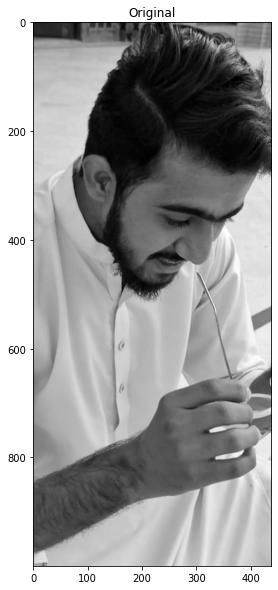

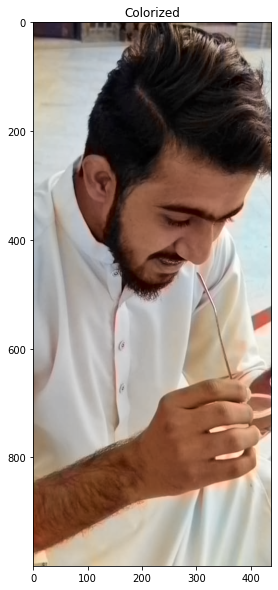

In [5]:
func('/content/pic 1.jpeg')

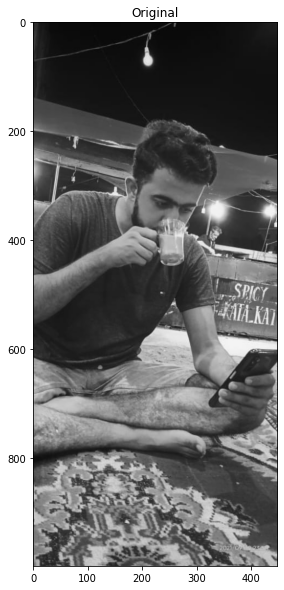

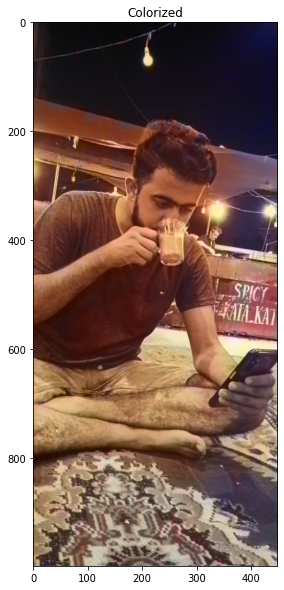

In [6]:
func('/content/pic2.jpeg')

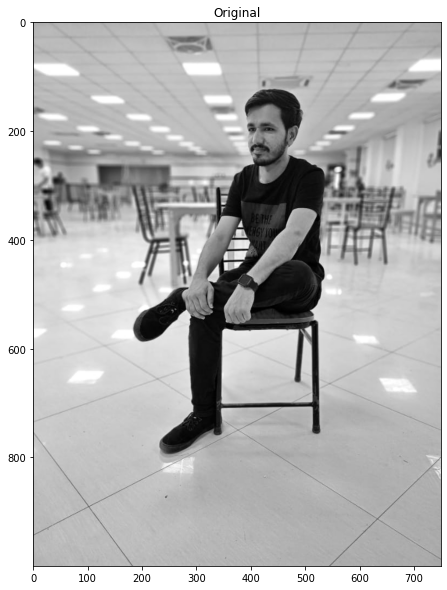

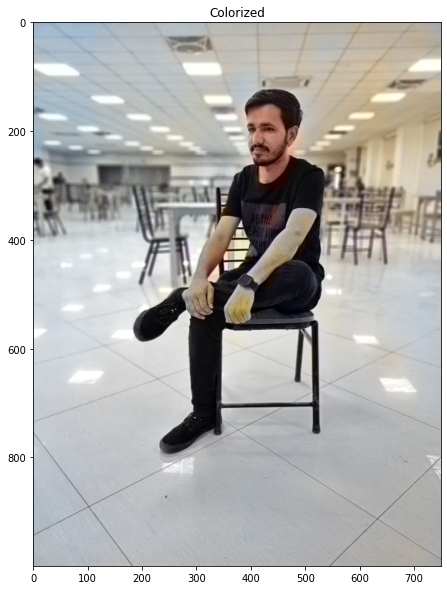

In [7]:
func('/content/pic3.jpeg')

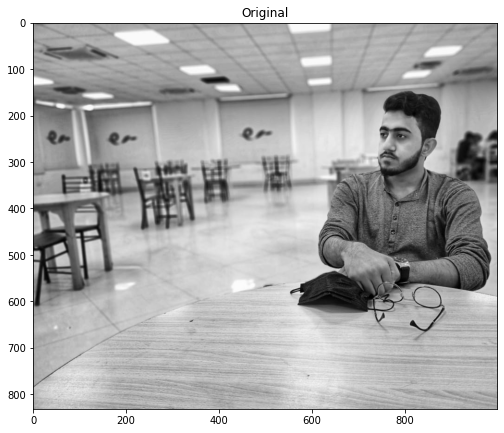

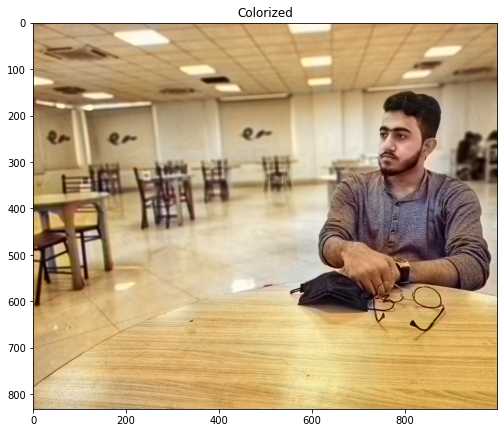

In [8]:
func('/content/pic4.jpeg')